In [3]:
### Preparing data

import pandas as pd

data = pd.read_pickle('../delhi.pickle').rename(columns={'pm25':'PM25_AQI_value'})
stations = data.location.unique().tolist()
data['station_id'] = data.location.apply(lambda x: stations.index(x)+1001)
data.head(2)

delhi_data = data.copy()

11 1028
0.05670241912206014 minutes


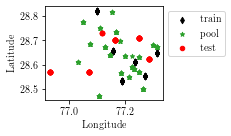

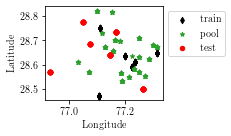

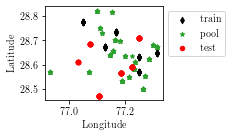

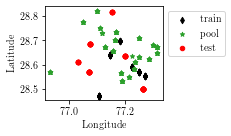

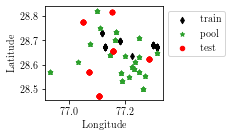

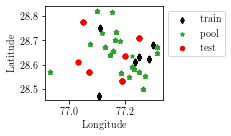

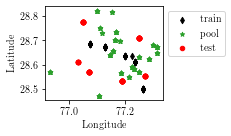

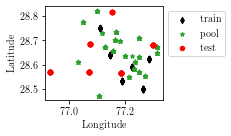

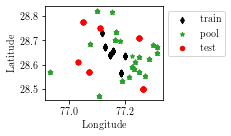

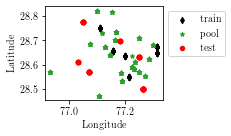

In [41]:
from time import time
init = time()
lhs_seed = 0
for seed in range(10):
    import pandas as pd
    from pyDOE2.doe_lhs import lhs
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.neighbors import KNeighborsRegressor
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from polire.placement.base import Base
    from IPython.display import clear_output
    import GPy
    from pyDOE2.doe_lhs import lhs
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import cdist

    import matplotlib.pyplot as plt
    from scipy import stats
    p = print

    from time import time
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from IPython.display import clear_output

    from sklearn.metrics import mean_squared_error, r2_score

    import seaborn as sns
    import sys
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib
    from matplotlib.animation import FuncAnimation
    from matplotlib import rc

    from math import sqrt
    SPINE_COLOR = 'gray'
    p = print

    def latexify(fig_width=None, fig_height=None, columns=1):
        """Set up matplotlib's RC params for LaTeX plotting.
        Call this before plotting a figure.

        Parameters
        ----------
        fig_width : float, optional, inches
        fig_height : float,  optional, inches
        columns : {1, 2}
        """

        # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

        # Width and max height in inches for IEEE journals taken from
        # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

        assert(columns in [1,2])

        if fig_width is None:
            fig_width = 3.39 if columns==1 else 6.9 # width in inches

        if fig_height is None:
            golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
            fig_height = fig_width*golden_mean # height in inches

        MAX_HEIGHT_INCHES = 8.0
        if fig_height > MAX_HEIGHT_INCHES:
            print("WARNING: fig_height too large:" + fig_height + 
                  "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
            fig_height = MAX_HEIGHT_INCHES

        params = {'backend': 'ps',
                  'text.latex.preamble': [r'\usepackage{gensymb}'],
                  'axes.labelsize': 10, # fontsize for x and y labels (was 10)
                  'axes.titlesize': 10,
                  'font.size': 10, # was 10
                  'legend.fontsize': 10, # was 10
                  'xtick.labelsize': 10,
                  'ytick.labelsize': 10,
                  'text.usetex': True,
                  'figure.figsize': [fig_width,fig_height],
                  'font.family': 'serif'
        }

        matplotlib.rcParams.update(params)

    def format_axes(ax):

        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_tick_params(direction='out', color=SPINE_COLOR)

        return ax

    ### Data

    data = delhi_data.copy()
    data.head(2)

    global_all_stations = data.station_id.unique()
    p(global_all_stations)

    ### Train, pool, test splits

    from sklearn.cluster import kmeans_plusplus
    tmpdata = data.drop_duplicates(subset=['station_id'])
    all_locs = tmpdata[['longitude', 'latitude']].values
    norm_all_locs = (all_locs - all_locs.min(axis=0))/(all_locs.max(axis=0) - all_locs.min(axis=0))
    while True:
        s = lhs(2, 6, random_state=lhs_seed)
        c_i = cdist(norm_all_locs, s).argmin(axis=0)
        lhs_seed += 1
        if len(set(c_i)) == 6:
            break
    ### Global config

    window = 1
    all_time = data.index.unique()[:-1]
    data = data.loc[all_time]
    Xcols = ['longitude', 'latitude']#, 'temperature', 'pressure', 'humidity', 'wind']
    ycols = ['PM25_AQI_value']

    np.random.seed(seed)
    ################## KMeans 
#     global_test_stations = global_all_stations[kmeans_plusplus(all_locs, n_clusters=6, random_state=seed)[1]]
    ################## Random
#     global_test_stations = global_all_stations[np.random.choice(len(global_all_stations), size=6, replace=False)]
    ################## LHS
    global_test_stations = global_all_stations[c_i]
    global_train_pool_stations = np.array(sorted(set(global_all_stations) - set(global_test_stations)))
    global_pool_stations, global_train_stations = train_test_split(global_train_pool_stations, test_size=6, random_state=seed)
    p('train', len(global_train_stations))
    p('test', len(global_test_stations))
    p('pool', len(global_pool_stations))

    pd.to_pickle(global_test_stations, 'global_test'+str(seed)+'lhs'+'.station')
    pd.to_pickle(global_train_stations, 'global_train'+str(seed)+'lhs'+'.station')

    latexify(3.32, 2)
    trn_locs = data[data.station_id.isin(global_train_stations)][['longitude', 'latitude']].drop_duplicates().values
    tst_locs = data[data.station_id.isin(global_test_stations)][['longitude', 'latitude']].drop_duplicates().values
    pool_locs = data[data.station_id.isin(global_pool_stations)][['longitude', 'latitude']].drop_duplicates().values

    print(trn_locs.shape, tst_locs.shape, pool_locs.shape)

    fig, ax = plt.subplots()
    ss = 20
    ax.scatter(trn_locs[:,0], trn_locs[:,1], c='black', s=ss, marker='d', label='train')
    ax.scatter(pool_locs[:,0], pool_locs[:,1], c='tab:green', s=ss, marker='*', label='pool')
    ax.scatter(tst_locs[:,0], tst_locs[:,1], c='red', s=ss, label='test')
    ax.legend(bbox_to_anchor=(1,1));
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    fig.tight_layout()
    fig.savefig('imgs/tpt'+str(seed)+'lhs'+'.pdf')
    ### svr + Random

    from sklearn.svm import SVR
    np.random.seed(0)

    train_stations = global_train_stations.copy().tolist()
    test_stations = global_test_stations.copy().tolist()
    pool_stations = global_pool_stations.copy().tolist()

    svrrand_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
    svrrand_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])
    svrrand_deploys = []

    for t_i in range(0,12, window):
    #     print('train', len(train_stations))
    #     print('pool', len(pool_stations))

        tmp_df = data.loc[all_time[t_i:t_i+window]]

        train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
        test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
        pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]

        xscaler = StandardScaler()
        yscaler = StandardScaler()
        xscaler.fit(train_df[Xcols])
        yscaler.fit(train_df[ycols])

        local_preds = []
        local_tests = []
        for local_t in tmp_df.index.unique():
            trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
            tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
            trn_y = yscaler.transform(train_df.loc[local_t][ycols])
            tst_y = test_df.loc[local_t][ycols]
    #         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)

#             model = RandomForestRegressor(random_state=0)
#             model = KNeighborsRegressor()
            model = SVR()
            model.fit(trn_X, trn_y)

            svrrand_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)).ravel()
            svrrand_result_df_tests.loc[local_t,:] = tst_y.values.ravel()

        ### Choosing next sensor
        np.random.seed(t_i)
        chosen_i = np.random.choice(len(pool_stations))
        clear_output(wait=True)
        svrrand_deploys.append(pool_stations[chosen_i])
        print(t_i, pool_stations[chosen_i])

        # Updating pool and train
        train_stations.append(pool_stations.pop(chosen_i))
        train_stations = sorted(train_stations)
    svrrand_result_df_preds.to_pickle("svrrand"+str(seed)+'lhs'+".pred")
    pd.to_pickle(svrrand_deploys, 'svrrand'+str(seed)+'lhs'+'.dep')

    p((time()-init)/60, 'minutes')

### Without KMeans++ Seeding

In [51]:
key = ''

In [52]:
Models = [['SVR+Random', 'svrrand']]

n_seed = 10
res_dict_pred = {name:np.random.rand(n_seed,12,6)*np.nan for name,_ in Models}
res_dict_test = {'test':np.random.rand(n_seed,12,6)*np.nan}
for seed in range(n_seed):
    for name, file in Models:
#         print(pd.read_pickle(file+str(seed)+'.pred').shape)
        res_dict_pred[name][seed,:,:] = pd.read_pickle(file+str(seed)+key+'.pred')
    res_dict_test['test'][seed,:,:] = pd.read_pickle('testdf'+str(seed)+key+'.pickle')

np.sqrt(np.square(res_dict_pred[Models[0][0]] - res_dict_test['test']).mean(axis=1)).mean()

11.764822388865383

In [53]:
Models = [['RF+Random', 'rfrand']]

n_seed = 10
res_dict_pred = {name:np.random.rand(n_seed,12,6)*np.nan for name,_ in Models}
res_dict_test = {'test':np.random.rand(n_seed,12,6)*np.nan}
for seed in range(n_seed):
    for name, file in Models:
#         print(pd.read_pickle(file+str(seed)+'.pred').shape)
        res_dict_pred[name][seed,:,:] = pd.read_pickle(file+str(seed)+key+'.pred')
    res_dict_test['test'][seed,:,:] = pd.read_pickle('testdf'+str(seed)+key+'.pickle')

np.sqrt(np.square(res_dict_pred[Models[0][0]] - res_dict_test['test']).mean(axis=1)).mean()

14.066069984795824

In [54]:
Models = [['KNN+Random', 'knnrand']]

n_seed = 10
res_dict_pred = {name:np.random.rand(n_seed,12,6)*np.nan for name,_ in Models}
res_dict_test = {'test':np.random.rand(n_seed,12,6)*np.nan}
for seed in range(n_seed):
    for name, file in Models:
#         print(pd.read_pickle(file+str(seed)+'.pred').shape)
        res_dict_pred[name][seed,:,:] = pd.read_pickle(file+str(seed)+key+'.pred')
    res_dict_test['test'][seed,:,:] = pd.read_pickle('testdf'+str(seed)+key+'.pickle')

np.sqrt(np.square(res_dict_pred[Models[0][0]] - res_dict_test['test']).mean(axis=1)).mean()

11.892982127218495

In [46]:
agg = {name:[] for name in res_dict_pred.keys()}
for i in range(0,276,window):
    for name in res_dict_pred.keys():
        tmp = []
        for seed in range(10):
            tmp.append(mean_squared_error(res_dict_test['test'][seed,i:i+window,:].ravel(), 
                         res_dict_pred[name][seed,i:i+window,:].ravel(), squared=False))
        agg[name].append(np.mean(tmp))

latexify(3.32,2)
for name in agg:
    plt.scatter(range(1,13), agg[name], label=name, marker='*')
plt.legend();
np.mean(agg[name])

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.